In [26]:
!nvidia-smi

Mon Dec 21 09:07:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  Off  | 00000000:00:07.0 Off |                    0 |
| N/A   33C    P0    37W / 250W |  16901MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
 #!pip3 install transformers

In [28]:
#!pip3 uninstall nltk --yes
#!pip3 install nltk 

In [29]:

import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from transformers import BertTokenizer, TFBertForSequenceClassification, TFBertForMaskedLM, TFTrainer, TFTrainingArguments, pipeline
from tensorflow.keras.models import Model,load_model, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
import pickle as pkl
import numpy as np
import nltk
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu, corpus_bleu
from nltk.translate.nist_score import sentence_nist, corpus_nist
from nltk.translate.meteor_score import meteor_score
import sys
nltk.download('wordnet')
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
import matplotlib.ticker as ticker
from wordcloud import WordCloud
from tqdm.notebook import tqdm

[nltk_data] Downloading package wordnet to /workspace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
#tomada de tempo de excução
runStart = datetime.now()

In [31]:
#
# MODO DE EXECUÇÃO DO NOTEBOOK
#
# Para evitar consumo de máquina e tempo este notebook pode ser executado de duas formas.
#
# False = usa pesos e outros parâmetros salvos. Não roda otimizações, usa do modelo
#       ja salvo, mas roda cálculos e gráficos.
#
# True = roda o notebook inteiro: todas otimizações, cálculos e gráficos.
#
#
RUN_MODE = False

In [32]:
TEXT_MAXLEN = 60
TITLE_MAXLEN = 10

max_length_review = 60
max_length_title = 10

TEXT_MAX_NB_WORDS = 60
TITLE_MAX_NB_WORDS = 5

CLS = '[CLS]'
SEP = '[SEP]'
MASK = '[MASK]'
EOS = '[SEP]'
#EOS = '[unused99]'
SPC = ' '

frac_corpus = .9

EPOCHS = 5
BATCH_SIZE = 128

In [33]:
#Importação do CORPUS no mesmo diz local no formato tsv
b2wCorpus = pd.read_csv('b2wCorpusFull.tsv',"\t",usecols=['review_title','review_text'], encoding='utf-8')# ,nrows=100)
b2wCorpus = b2wCorpus.rename(columns={'review_title': 'title', 'review_text': 'review'})
lines = len(b2wCorpus.index)
b2wCorpus.head()

,title,review
0,bom,estou contente com a compra entrega rápida o ú...
1,"preço imbatível, ótima qualidade","por apenas r$1994.20,eu consegui comprar esse ..."
2,atende todas as expectativa.,supera em agilidade e praticidade outras panel...
3,presente mais que desejado,meu filho amou! parece de verdade com tantos d...
4,"sem duvidas, excelente","a entrega foi no prazo, as americanas estão de..."


In [34]:
lines

132373

In [35]:
# Pré-processamento
def cleanning(text, stem=False):
  text = text.replace("@"," ")
  text = re.sub('[*)@#%(&$_^~]', '', text)
  text = re.sub(r'([?!.])\1+', r'\1', text)
  text = re.sub(r"([?.!,¿])", r" \1 ", text)
  text = re.sub(r'[" "]+', " ", text)
  text = re.sub("\d+", "", text).strip()
  return text

In [36]:
b2wCorpus.review = b2wCorpus.review.apply(lambda x: cleanning(x))
b2wCorpus.title = b2wCorpus.title.apply(lambda x: cleanning(x))
b2wCorpus.drop_duplicates(subset=['review'], inplace=True)
b2wCorpus.dropna(axis=0,inplace=True)
b2wCorpus.head()

,title,review
0,bom,estou contente com a compra entrega rápida o ú...
1,"preço imbatível , ótima qualidade","por apenas r . , eu consegui comprar esse lin..."
2,atende todas as expectativa .,supera em agilidade e praticidade outras panel...
3,presente mais que desejado,meu filho amou ! parece de verdade com tantos ...
4,"sem duvidas , excelente","a entrega foi no prazo , as americanas estão d..."


In [37]:
# Recorte do corpus baseado no max_length_review e no max_length_title
b2wCorpus=b2wCorpus.sample(frac=1).reset_index(drop=True)
def tamanho(text):
    return len(text.split())
b2wCorpus = b2wCorpus[b2wCorpus['review'].apply(tamanho) > 3]
b2wCorpus = b2wCorpus[b2wCorpus['review'].apply(tamanho) <= max_length_review]
b2wCorpus = b2wCorpus[b2wCorpus['title'].apply(tamanho) > 0 ]
b2wCorpus = b2wCorpus[b2wCorpus['title'].apply(tamanho) <= max_length_title]

In [38]:
b2wCorpus.shape

(116780, 2)

In [39]:
# Atualizando tamanho, index e suffling do dataframe do corpus

lines = int(lines * frac_corpus)
b2wCorpus=b2wCorpus.head(lines)
b2wCorpus=b2wCorpus.sample(frac=1).reset_index(drop=True)
b2wCorpus.shape

(116780, 2)

In [40]:
b2wCorpus.head(200)

,title,review
0,produto de péssima qualidade,"no primeiro uso já rasgou uma tira elástica , ..."
1,produto de ótima aceitação .,a minha esposa usa esse produto já há algum te...
2,aspirador de pó philco rapid n vermelho/preto - w,produto excelente . cumpriu tudo que se espera...
3,tv ótima,comprei duas uma para a cozinha e a outra para...
4,ótimo,já fiz dois cortes e funcionou muito bem e par...
...,...,...
195,perfeito !,travesseiro da nasa só que não esquenta como o...
196,ótimo custo/benefício,"ótimo material , ótimo preço , vale a pena ! e..."
197,moto minuscula,demorei dias pra receber o produto e me decep...
198,violão hofma,"o violão é muito bom em si , só tem a parte de..."


In [41]:
def generate_pairs(text, title, text_max_nb_words=None, title_max_nb_words=None):
    '''
    Generate pairs for summary task
    with bert
    Args:
        text (numpy:list) : numpy array with lists of text reviews
        title (numpy:list) : numpy array with lists of title reviews
        text_max_nb_words (int) : max number of words to truncate text review
        title_max_nb_words (int) : max number of words to truncate title review
    returns:
        pairs (list of strings, list of strings) : pairs with lists of strings of 
        text and title 
    '''
    pairs = []
    text_truncated = ' '.join(text.split()[:text_max_nb_words])
    title_truncated = ' '.join(title.split()[:title_max_nb_words]) + SPC + EOS + SPC
    spl = title_truncated.split()

    for w in range(len(spl)):
        # new_text = CLS + SPC + text_truncated + SPC + SEP + SPC + ' '.join(spl[:w]) + SPC + MASK + SPC + SEP
        new_text = text_truncated + SPC + SEP + SPC + ' '.join(spl[:w]) + SPC + MASK
        # pairs.append([new_text, spl[w]])
        new_output = text_truncated + SPC + SEP + SPC + ' '.join(spl[:w]) + SPC + spl[w]
        pairs.append([new_text, new_output])
        
    return pairs

In [42]:
def generate_samples(text, title, text_max_nb_words=None, title_max_nb_words=None):
    '''
    Generate samples for summary task - helper function
    with bert
    Args:
        text (numpy:list) : numpy array with lists of text reviews
        title (numpy:list) : numpy array with lists of title reviews
        text_max_nb_words (int) : max number of words to truncate text review
        title_max_nb_words (int) : max number of words to truncate title review
    returns:
        (text, title) (list of strings, list of strings) :  samples
    '''
    new_text = []
    new_title = []
    
    for i in range(len(text)):
        pairs = generate_pairs(text[i], title[i], text_max_nb_words, title_max_nb_words)
        new_text.extend([sample[0] for sample in pairs])
        new_title.extend([sample[1] for sample in pairs])
    
    return new_text, new_title

In [43]:
def tokenize(sentences, tokenizer=None, ref_model = None, maxlen=50, add_special_tokens=True):
    '''
    Encodes a string to an array of integers

    Args:
        sentences (list): list of human-readable strings to encode  
        tokenizer () : Bert tokenizer instance
        ref_model (str) : bert reference model
        maxlen (int) : max length of a sequence to pad and truncate
    Returns:
        (dict : numpy array) input_ids, token_type_ids, attention_mask
        Tokenizer: Bert tokenizer instance
    '''
    # Bert Tokenizer
    if tokenizer is None:
      tokenizer = BertTokenizer.from_pretrained(ref_model)
      tokenizer.eos_token = EOS
      # tokenizer = BertTokenizer.from_pretrained(ref_model, eos_token=EOS) # Não funciona a loss da nan
    
    # tokenizer.add_tokens([EOS]) # Não funciona a loss da nan
    
    encoded = tokenizer(
        [[line] for line in sentences],
        text_pair=None,
        is_split_into_words=True,
        padding="max_length",
        truncation=True,
        max_length=maxlen,
        pad_to_max_length=True,
        return_tensors='np',
        add_special_tokens=add_special_tokens)
    
    return encoded, tokenizer

In [44]:
def predict_and_decode_sequences(data, model, sent_max_len, sent_max_nb_words, seq_max_len, tokenizer):
  '''
  Predicts the title review given
  a text review sentence.
  args:
    data (list:str) or (numpy array:str) - list/array 
    of human readable strings

    model (keras model) : keras model used to predict
    the sentence title review
    
    sent_max_len (int) : max number of characters of the
    predicted sentence

    sent_max_nb_words (int) : max number of words of the
    predicted sentence

    seq_max_len (int) : sequence max length

    tokenizer (Bert pretreined tokenizer) - Bert tokenizer

  returns:
    sentences (list:str) : list of predicted titles
  '''

  sentences = []
  with tqdm(total=len(data)) as pbar:
    for sentence in data:
      next_sent = ' '.join(sentence.split()[:sent_max_nb_words]) + SPC + SEP + MASK
      result = ''
      predicted_word = ''

      while len(result) <= sent_max_len and predicted_word != EOS:
        # Tokenize sentence and get the index of [MAK]
        # tokenized_sent = tok(next_sent)
        tokenized_sent, _ = tokenize([next_sent], tokenizer, maxlen=seq_max_len)
        mask_idx = np.where(tokenized_sent['input_ids'][0] == tokenizer.mask_token_id)[0]
        if len(mask_idx) == 0:
          break
        mask_idx = mask_idx[0]
        # Make prediction and get the word indexes
        pred = model.predict([tokenized_sent['input_ids'], tokenized_sent["attention_mask"]])
        prediction = np.argmax(pred.logits, axis=-1)
        # decode predicted sequence to human readable string
        new_sent = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(prediction[0][0:mask_idx]))
        predicted_word = tokenizer.ids_to_tokens[int(prediction[0][mask_idx-1])]

        if predicted_word != EOS:
          result = result + predicted_word + ' '
        # make the new sentence ready for a new prediction
        next_sent = new_sent + SPC + MASK
      sentences.append(result.strip())
      pbar.update(1)
  sentences = list(map( lambda x : re.sub(' ##','',x),sentences))
  return sentences

In [45]:
review_text_ = b2wCorpus['review'].values
title_text_ = b2wCorpus['title'].values

In [46]:
# Print de amostra do titulo e do review
for j in range(9):
    print("\n\ntitle: " + title_text_[j])
    print("\nreview: " +  review_text_[j])



title: produto de péssima qualidade

review: no primeiro uso já rasgou uma tira elástica , não recomendo .


title: produto de ótima aceitação .

review: a minha esposa usa esse produto já há algum tempo . usou a primeira vez , gostou e continuou .


title: aspirador de pó philco rapid n vermelho/preto - w

review: produto excelente . cumpriu tudo que se esperava dentro das condições utilizadas .


title: tv ótima

review: comprei duas uma para a cozinha e a outra para o quartinho de serviço , funciona super bem imagem e som perfeito .


title: ótimo

review: já fiz dois cortes e funcionou muito bem e parabéns a entrega super rápida da americanas .


title: ótimo produto

review: o produto corresponde ao que foi informado no site . tem um ótimo desempenho das funções !


title: outra marca do produto

review: estou decepcionada com a compra na americanas pelo site não veio o produto correto que eu pedi eu pedi a escova giratória rotativa seca , modela e alisa da marca - ufree , porém

In [47]:
# Função de split de dados
def train_validate_test_split(df, train_percent=.70, validate_percent=.15, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

b2wCorpusTrain, b2wCorpusValidate, b2wCorpusTest = train_validate_test_split(b2wCorpus)

In [48]:
# Split
b2wCorpusTrain, b2wCorpusValidate, b2wCorpusTest = train_validate_test_split(b2wCorpus)

# Criação das séries
# Treino, Validação e Teste
X_train =  b2wCorpusTrain.review.values.tolist()
y_train =  b2wCorpusTrain.title.values.tolist()

X_val = b2wCorpusValidate.review.values.tolist()
y_val = b2wCorpusValidate.title.values.tolist()

X_test = b2wCorpusTest.review.values.tolist()
y_test = b2wCorpusTest.title.values.tolist()

len(X_train),len(X_val), len(X_test)


(81746, 17517, 17517)

In [49]:
X_test_inf = X_test.copy()
y_test_inf  = y_test.copy()

In [50]:
X_train, y_train = generate_samples(X_train, y_train, TEXT_MAX_NB_WORDS, TITLE_MAX_NB_WORDS)
X_val, y_val = generate_samples(X_val, y_val, TEXT_MAX_NB_WORDS, TITLE_MAX_NB_WORDS)
X_test, y_test = generate_samples(X_test, y_test, TEXT_MAX_NB_WORDS, TITLE_MAX_NB_WORDS)

In [51]:
for i in range(15):
    print(X_train[i], '\n', y_train[i]) 
    print('\n\n')

permite moer o café na granularidade ideal para diversos tipos de equipamentos de extração prensa , moka , etc . [SEP]  [MASK] 
 permite moer o café na granularidade ideal para diversos tipos de equipamentos de extração prensa , moka , etc . [SEP]  autonomia



permite moer o café na granularidade ideal para diversos tipos de equipamentos de extração prensa , moka , etc . [SEP] autonomia [MASK] 
 permite moer o café na granularidade ideal para diversos tipos de equipamentos de extração prensa , moka , etc . [SEP] autonomia para



permite moer o café na granularidade ideal para diversos tipos de equipamentos de extração prensa , moka , etc . [SEP] autonomia para [MASK] 
 permite moer o café na granularidade ideal para diversos tipos de equipamentos de extração prensa , moka , etc . [SEP] autonomia para experimentar



permite moer o café na granularidade ideal para diversos tipos de equipamentos de extração prensa , moka , etc . [SEP] autonomia para experimentar [MASK] 
 permite moer o

In [52]:
SEQUENCE_MAXLEN = TEXT_MAXLEN + TITLE_MAXLEN + 2
REF_MODEL = 'neuralmind/bert-base-portuguese-cased'

X_train, X_train_tokenizer = tokenize(X_train, None, REF_MODEL, SEQUENCE_MAXLEN)
X_val, _ = tokenize(X_val, X_train_tokenizer, REF_MODEL, SEQUENCE_MAXLEN)
X_test, _ = tokenize(X_test, X_train_tokenizer, REF_MODEL, SEQUENCE_MAXLEN)

y_train, y_train_tokenizer = tokenize(y_train, None, REF_MODEL, SEQUENCE_MAXLEN, False)
y_val, _ = tokenize(y_val, y_train_tokenizer, REF_MODEL, SEQUENCE_MAXLEN, False)
y_test, _ = tokenize(y_test, y_train_tokenizer, REF_MODEL, SEQUENCE_MAXLEN, False)

In [53]:
TEXT_VOC_SIZE = len(X_train_tokenizer.get_vocab())
TITLE_VOC_SIZE = len(y_train_tokenizer.get_vocab())

In [54]:
print('Shapes dos conjuntos após realizar todas as etapas necessárias')
print()
print('TEXT')
print('=======================')
print('Train:', X_train['input_ids'].shape)
print('Val:  ',X_val['input_ids'].shape)
print('Test: ', X_test['input_ids'].shape)
print('=======================')
print()
print('TITLE:')
print('=======================')
print('Train: ', y_train['input_ids'].shape)
print('Val:   ', y_val['input_ids'].shape)
print('Test   ', y_test['input_ids'].shape)
print('=======================')

Shapes dos conjuntos após realizar todas as etapas necessárias

TEXT
Train: (306976, 72)
Val:   (65985, 72)
Test:  (65684, 72)

TITLE:
Train:  (306976, 72)
Val:    (65985, 72)
Test    (65684, 72)


In [55]:
print('Tamanho dos vocabulários - Vocabulários restritos ao conjunto de treino apenas')
print()
print('=======================')
print('Text:', TEXT_VOC_SIZE, 'palavras')
print('=======================')
print()
print('=======================')
print('Title:', TITLE_VOC_SIZE, 'palavras')
print('=======================')

Tamanho dos vocabulários - Vocabulários restritos ao conjunto de treino apenas

Text: 29794 palavras

Title: 29794 palavras


In [56]:
# CLS = '[CLS]'
# SEP = '[SEP]'
# MASK = '[MASK]'
# EOS = '[SEP]'
# #EOS = '[unused99]'
# SPC = ' '
# REF_MODEL = 'neuralmind/bert-base-portuguese-cased'
# tokenizer = BertTokenizer.from_pretrained(REF_MODEL)
# print(REF_MODEL)
# print('[CLS]',tokenizer.convert_tokens_to_ids(['[CLS]']))
# print('[SEP]',tokenizer.convert_tokens_to_ids(['[SEP]']))
# print('[MASK]',tokenizer.convert_tokens_to_ids(['[MASK]']))
# print('[EOS]',tokenizer.convert_tokens_to_ids(['[EOS]']))
# print(tokenizer.convert_ids_to_tokens([104]))
# print(tokenizer.convert_ids_to_tokens([105]))
# # print(tokenizer.eos_token_id)
# frase = "Ricardo gostei de água.[SEP] Veio com defeito[MASK]. Eu gostei muito do produto."
# a = tokenizer.encode(frase,add_special_tokens=False)
# print(a)
# b = tokenizer.convert_ids_to_tokens(a)
# print(b)
# c = tokenizer.convert_tokens_to_string(b)
# print(c)
# #predicted_word = tokenizer.ids_to_tokens(a)
# REF_MODEL = 'bert-base-uncased'
# print(REF_MODEL)
# tokenizer = BertTokenizer.from_pretrained(REF_MODEL )
# print(tokenizer.cls_token_id, tokenizer.sep_token_id,tokenizer.eos_token_id,tokenizer.mask_token_id)
# print('[CLS]',tokenizer.convert_tokens_to_ids(['[CLS]']))
# print('[SEP]',tokenizer.convert_tokens_to_ids(['[SEP]']))
# print('[MASK]',tokenizer.convert_tokens_to_ids(['[MASK]']))
# print('[EOS]',tokenizer.convert_tokens_to_ids(['[EOS]']))
# print(tokenizer.convert_ids_to_tokens([104]))
# print(tokenizer.convert_ids_to_tokens([105]))




In [57]:

# Rede: arquitetura, configurações, parâmetros e otimização
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
with tf.device('GPU:0'):
    from keras import backend as K 
    #K.clear_session() 

    bert_model = TFBertForMaskedLM.from_pretrained(REF_MODEL, from_pt=True)
    input_ids = tf.keras.layers.Input(shape=(SEQUENCE_MAXLEN,), name='input_token', dtype='int32')
    input_masks_ids = tf.keras.layers.Input(shape=(SEQUENCE_MAXLEN,), name='masked_token', dtype='int32')
    X = bert_model(input_ids, input_masks_ids)

    # Definição da model
    model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)
    model.summary()
    plot_model(model, to_file='Bert_train_model.png', show_shapes=True)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-07)
    my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)]
    model.compile(opt, loss, metrics=[metric])
    if RUN_MODE:
        history = model.fit(
                [X_train["input_ids"],
                X_train["attention_mask"]],
                y_train["input_ids"],
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                callbacks=my_callbacks,
                validation_data = ([X_val["input_ids"],
                                X_val["attention_mask"]],
                                y_val["input_ids"])
        )
        with open('BERT_history.history', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
    else:
        with open('BERT_history.history', 'rb') as file_pi:
            history = pickle.load(file_pi)

All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fc94e857430> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fc94e857430> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 72)]         0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 72)]         0                                            
__________________________________________________________________________________________________
tf_bert_for_masked_lm (TFBertFo TFMaskedLMOutput(los 108954466   input_token[0][0]                
                                                                 masked_token[0][0]               
Total params: 108,954,466
Trainable params: 108,954,466
Non-trainable params: 0
__________________________________________________________________________________________________
('Faile

In [58]:
if RUN_MODE:
    model.evaluate([X_test["input_ids"],
                    X_test["attention_mask"]], 
                y_test["input_ids"])

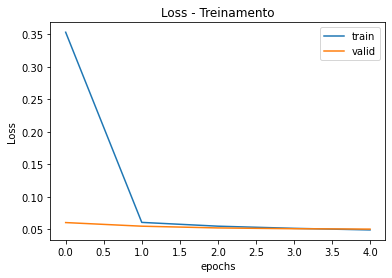

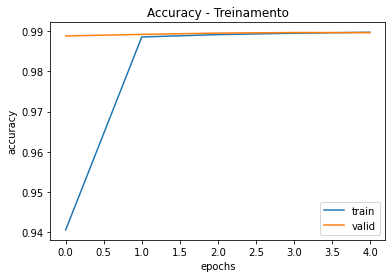

<Figure size 432x288 with 0 Axes>

In [59]:
## Gráfico da loss e da acurácia
import matplotlib.pyplot as plt 
plt.title('Loss - Treinamento')
plt.xlabel('epochs')
plt.ylabel('Loss')
if RUN_MODE:
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='valid')
else:
    plt.plot(history['loss'], label='train')
    plt.plot(history['val_loss'], label='valid')
plt.legend()
plt.show()
plt.clf()

plt.title('Accuracy - Treinamento')
plt.xlabel('epochs')
plt.ylabel('accuracy')
if RUN_MODE:
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
else:
    plt.plot(history['accuracy'], label='train')
    plt.plot(history['val_accuracy'], label='valid')
plt.legend()
plt.show()
plt.clf()

In [60]:
if RUN_MODE:
    y_pred = predict_and_decode_sequences(X_test_inf, model, TITLE_MAXLEN, TEXT_MAX_NB_WORDS, SEQUENCE_MAXLEN, X_train_tokenizer)

In [61]:
if RUN_MODE:
    for i in range(1, 100):
        print("Text Review:", X_test_inf[i])
        print("Original Title Review:", y_test_inf[i])
        print("Predicted Title Review:", y_pred[i])
        print("\n")

In [62]:
# Predict
if RUN_MODE:
  dfResults =  pd.DataFrame(columns=['Review','Original','Predicted','NIST','BLEU','METEOR'])
  size = len(X_test_inf)
  with tqdm(total=size) as pbar:  
    for i in range(size):
      review = X_test_inf[i]
      original = y_test_inf[i]
      predicted = y_pred[i]
      dfResults = dfResults.append({'Review': review, 'Original': original,'Predicted': predicted}, ignore_index=True)
      pbar.update(1)
    dfResults.to_pickle('BERT_dfResults.df')
else:
  dfResults =  pd.read_pickle('BERT_dfResults.df')

In [63]:
# Checa o resultado do predict
dfResults.head(50)

,Review,Original,Predicted,NIST,BLEU,METEOR
0,tv com ótimo custo benefício . ótimo som e exc...,produto muito bom .,ótimo custo,NaN,NaN,NaN
1,"custo benefício bons , não tive nenhum problem...",muito bom,goste do,NaN,NaN,NaN
2,comprei o desse anúncio com o selo work with g...,recebi diferente do comprado,não é o que,NaN,NaN,NaN
3,atendeu às expectativas envio dentro do prazo ...,gostei,goste muito,NaN,NaN,NaN
4,comprei e não recebi o produto ! minha a avali...,o produto não foi entregue,não recebi,NaN,NaN,NaN
5,estou muito feliz pela compra e foi rapido a e...,maravilhoso de mas .,goste muito,NaN,NaN,NaN
6,"jogo excelente , com gráficos ótimos e jogabil...",ótimo,excelente,NaN,NaN,NaN
7,foi entregue mas não veio o meu nano usb . o q...,cade o usb nano,não veio o,NaN,NaN,NaN
8,ótimo custo benefício este aparelho atendeu pe...,aparelho bom,ótimo custo,NaN,NaN,NaN
9,produto muito bom e foi presente para o meu af...,o produto é muito bom,goste muito,NaN,NaN,NaN


[nltk_data] Downloading package stopwords to /workspace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
No handles with labels found to put in legend.


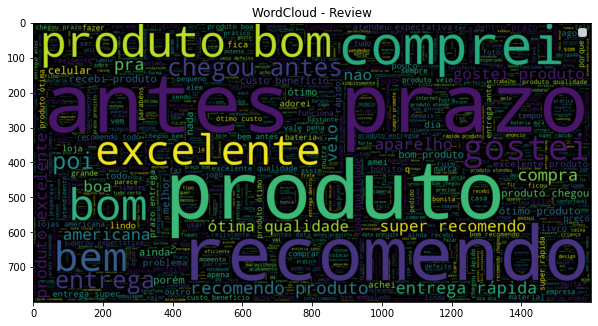

In [64]:
# WordCloud do Review
tokens = []
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
size = len(dfResults.index)
for i in range(size):
    text = dfResults.iloc[i].Review
    for token in text.split():
        if token not in stop_words:
            tokens.append(token)
plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(tokens))
plt.title('WordCloud - Review')
plt.legend()
plt.imshow(wc , interpolation = 'bilinear')

No handles with labels found to put in legend.


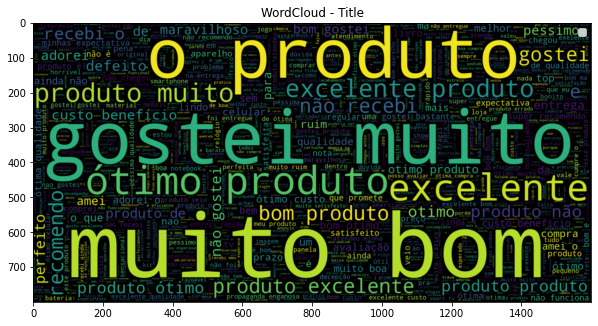

In [65]:
# WordCloud do do Title
plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(dfResults.Original))
plt.title('WordCloud - Title')
plt.legend()
plt.imshow(wc , interpolation = 'bilinear')

No handles with labels found to put in legend.


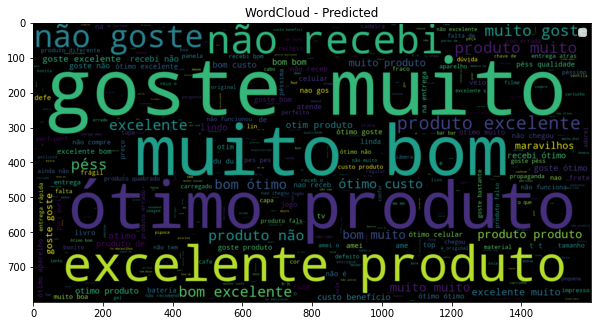

In [66]:
# WordCloud do Predicted (y_test)
plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(dfResults.Predicted))
plt.title('WordCloud - Predicted')
plt.legend()
plt.imshow(wc , interpolation = 'bilinear')

In [67]:
# Cálculo da métrica NIST
size = len(dfResults.index)
with tqdm(total=size) as pbar:  
  for i in range(size):
    reference = dfResults.iloc[i].Original
    candidate = dfResults.iloc[i].Predicted
    if reference != '' and candidate != '':         
            nist = sentence_nist([reference.split()], candidate.split(),1)  
            dfResults.iloc[i,3] = nist
    pbar.update(1)


Métricas para o NIST

Minímo: 0.0
Média: 0.091
Máximo: 1.585
Média: Ponderada 0.058
Desvio Padrão: 0.222
% CV: 243.138  %



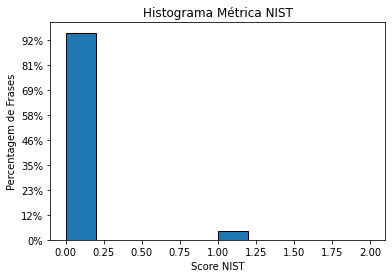

In [68]:
# Relatório do NIST
print("Métricas para o NIST\n")
data = dfResults[dfResults['NIST'].notna()]['NIST'].values
print("Minímo:", round(np.min(data),3))
m = np.mean(data)
print("Média:", round(m,3))
print("Máximo:", round(np.max(data),3))
print("Média: Ponderada", round(m/np.max(data),3))
sdev = round(np.std(data),3)
print("Desvio Padrão:", round(sdev,3))
cv = round((sdev/m)*100,3)
print("% CV:", cv, ' %\n')

aNIST = dfResults[dfResults['NIST'].notna()]['NIST'].values
WordsaNIST = np.round(aNIST.astype(np.double))

num_of_points = len(WordsaNIST)
data = WordsaNIST
fig, ax = plt.subplots()
ax.hist(data,  edgecolor='black')
ax.set_title("Histograma Métrica NIST")
ax.set_xlabel("Score NIST")
ax.set_ylabel("Percentagem de Frases")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(data)))
plt.show()

In [69]:
# Cáclculo da métrica BLEU
err = 0
size = len(dfResults.index)
with tqdm(total=size) as pbar:  
  for i in range(size):
      reference = dfResults.iloc[i].Original
      candidate = dfResults.iloc[i].Predicted
      pbar.update(1)
      if reference != '' and candidate != '':
            cc = SmoothingFunction()
            dfResults.iloc[i,4] = sentence_bleu([reference.split()], candidate.split(),smoothing_function=cc.method1)


Métricas para o BLEU

Minímo: 0
Média: 0.033
Média: Ponderada 0.058
Máximo: 0.562
Desvio Padrão: 0.067
% CV: 205.465  %



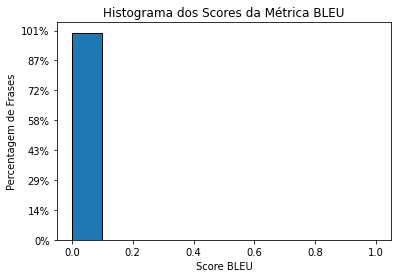

In [70]:
# Relatório do BLEU
print("Métricas para o BLEU\n")
data = dfResults[dfResults['BLEU'].notna()]['BLEU'].values
print("Minímo:", round(np.min(data),3))
m = np.mean(data)
print("Média:", round(m,3))
print("Média: Ponderada", round(m/np.max(data),3))
print("Máximo:", round(np.max(data),3))
sdev = round(np.std(data),3)
print("Desvio Padrão:", round(sdev,3))
cv = round((sdev/m)*100,3)
print("% CV:", cv, ' %\n')
aBLEU = dfResults[dfResults['BLEU'].notna()]['BLEU'].values
WordsaBLEU = np.round(aBLEU.astype(np.double))
num_of_points = len(WordsaBLEU)
num_of_bins = 11
data = WordsaBLEU
fig, ax = plt.subplots()
ax.hist(data, bins=[j/100 for j in range(0,110,10)], edgecolor='black')
ax.set_title("Histograma dos Scores da Métrica BLEU")
ax.set_xlabel("Score BLEU")
ax.set_ylabel("Percentagem de Frases")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(data)))
plt.show()

In [71]:
# Cálculo da métrica METEOR
err = 0
size = len(dfResults.index)
with tqdm(total=size) as pbar:  
  for i in range(size):
    reference = dfResults.iloc[i].Original
    candidate = dfResults.iloc[i].Predicted
    if reference != '' and candidate != '':
            meteor = meteor_score([reference], candidate)  
            dfResults.iloc[i,5] = meteor

    pbar.update(1)

Métricas para o METEOR

Minímo: 0.0
Média: 0.09
Média: Ponderada 0.091
Máximo: 0.981
Desvio Padrão: 0.188
% CV: 209.551  %



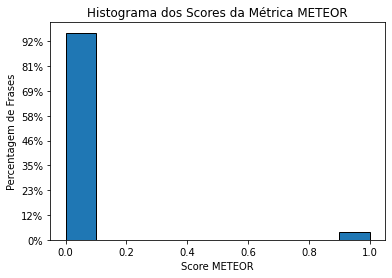

In [72]:
# Relatório do Meteor
print("Métricas para o METEOR\n")
data = dfResults[dfResults['METEOR'].notna()]['METEOR'].values
print("Minímo:", round(np.min(data),3))
m = np.mean(data)
print("Média:", round(m,3))
print("Média: Ponderada", round(m/np.max(data),3))
print("Máximo:", round(np.max(data),3))
sdev = round(np.std(data),3)
print("Desvio Padrão:", round(sdev,3))
cv = round((sdev/m)*100,3)
print("% CV:", cv, ' %\n')
aMETEOR = dfResults[dfResults['METEOR'].notna()]['METEOR'].values
WordsaMETEOR = np.round(aMETEOR.astype(np.double))
num_of_points = len(WordsaMETEOR)
num_of_bins = 11
data = WordsaMETEOR
fig, ax = plt.subplots()
ax.hist(data, bins=[j/100 for j in range(0,110,10)], edgecolor='black')
ax.set_title("Histograma dos Scores da Métrica METEOR")
ax.set_xlabel("Score METEOR")
ax.set_ylabel("Percentagem de Frases")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(data)))
plt.show()

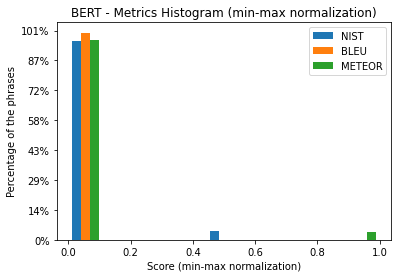

In [73]:
bins = np.linspace(0, 1, 10)
WordsaNISTh = WordsaNIST/np.max(WordsaNIST)
WordsaBLEUh = WordsaBLEU/np.max(WordsaBLEU)
WordsaMETEORh = WordsaMETEOR/np.max(WordsaMETEOR)
fig, ax = plt.subplots()
bins = np.linspace(0, 1, 10)
ax.hist((WordsaNISTh,WordsaBLEUh,WordsaMETEORh), bins,  label=('NIST','BLEU','METEOR'))
ax.legend(loc='upper right')
ax.set_title("BERT - Metrics Histogram (min-max normalization)")
ax.set_xlabel("Score (min-max normalization)")
ax.set_ylabel("Percentage of the phrases")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(data)))
plt.show()

In [74]:
# Analise de Tamanho do Title e do Predicted
def dicionarios_size(dfResult):
    Review = []
    Original = []
    fcOriginal = []
    Predicted = []
    fcPredicted = []
    size = len(dfResult.index)
    for i in range(size):
        Review = Review + dfResult.iloc[i].Review.split()
        Original = Original + dfResult.iloc[i].Original.split()
        fcOriginal.append(len(dfResult.iloc[i].Original.split())) 
        Predicted = Predicted + dfResult.iloc[i].Predicted.split()
        fcPredicted.append(len(dfResult.iloc[i].Predicted.split()))
    return len(np.unique(Review)) , len(np.unique(Original)), len(np.unique(Predicted)), fcOriginal,fcPredicted

r, o, p, fco,fcp = dicionarios_size(dfResults)

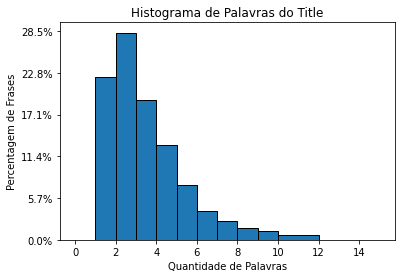

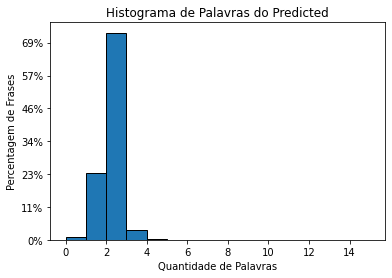


Tamanho de Dicionários
Review: 15997 palavras 
Title: 4244 palavras 
Predicted: 907 palavras

Métricas para o Title (em palavras)
Minímo: 1
Média: 2.964
Máximo: 10
Desvio Padrão: 1.866
% CV: 62.962  %

Métricas para o Predicted (em palavras)
Minímo: 0
Média: 1.784
Máximo: 6
Desvio Padrão: 0.525
% CV: 29.433  %

Diferença no tamanho do dicionário do Title e do Predicted: 3337.0 palavras ou 367.9162 %
Diferença no tamanho médio entre as frases do Title e do Predicted: 1.18 palavras ou 66.1546 %
Diferença no % CV Máquina entre o Title e do Predicted: 33.529 % ou relativa: 113.9164 %



In [75]:
# Relatório das medidas de contagem de palabras
Words = fco
num_of_points = len(Words)
num_of_bins = 20 
data = Words
fig, ax = plt.subplots()
ax.hist(data, bins=[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15], edgecolor='black')
ax.set_title("Histograma de Palavras do Title")
ax.set_xlabel("Quantidade de Palavras")
ax.set_ylabel("Percentagem de Frases")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(data)))
plt.show()

Words = fcp
num_of_points = len(Words)
num_of_bins = 20 
data = Words
fig, ax = plt.subplots()
ax.hist(data, bins=[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15], edgecolor='black')
ax.set_title("Histograma de Palavras do Predicted")
ax.set_xlabel("Quantidade de Palavras")
ax.set_ylabel("Percentagem de Frases")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(data)))
plt.show()

print("\nTamanho de Dicionários")
print('Review: ' + str(r) + ' palavras \nTitle: ' + str(o) + ' palavras \nPredicted: ' + str(p)+ ' palavras')

print("\nMétricas para o Title (em palavras)")
print("Minímo:", round(np.min(fco),3))
m = np.mean(fco)
print("Média:", round(m,3))
print("Máximo:", round(np.max(fco),3))
sdev = round(np.std(fco),3)
print("Desvio Padrão:", round(sdev,3))
cvT = round((sdev/m)*100,3)
print("% CV:", cvT, ' %')

print("\nMétricas para o Predicted (em palavras)")
print("Minímo:", round(np.min(fcp),3))
m = np.mean(fcp)
print("Média:", round(m,3))
print("Máximo:", round(np.max(fcp),3))
sdev = round(np.std(fcp),3)
print("Desvio Padrão:", round(sdev,3))
cvP = round((sdev/m)*100,3)
print("% CV:", cvP, ' %\n')

print('Diferença no tamanho do dicionário do Title e do Predicted:',round(np.mean(o)-np.mean(p),4), 'palavras ou' , round((np.mean(o)-np.mean(p))/np.mean(p)*100,4),'%')
print('Diferença no tamanho médio entre as frases do Title e do Predicted:',round(np.mean(fco)-np.mean(fcp),4), 'palavras ou' , round((np.mean(fco)-np.mean(fcp))/np.mean(fcp)*100,4),'%')
print('Diferença no % CV Máquina entre o Title e do Predicted:',round(cvT-cvP,4), '% ou relativa:' , round((cvT-cvP)/cvP*100,4),'%\n')

In [76]:
# Exportação dos resultados do corpo de Teste (corpus, predicted e métricas)
dfResults.to_csv('BERT_b2wCorpusFulldfResults.tsv', sep = '\t',index = False)

In [77]:

runEnd = datetime.now()
runTime = (runEnd - runStart).total_seconds() / 60.0
print("Run time elapsed:",round(runTime,0),'minutes')


Run time elapsed: 7.0 minutes
